In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2, os
import numpy as np
from glob import glob
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

dataset_dir = '/content/drive/MyDrive/ML/Datasets/mvtec_ad/normal'
scales = [768, 384, 192]

class MultiScaleDataset(Dataset):
    def __init__(self, img_dir, scales):
        self.paths = glob(os.path.join(img_dir, '*.png')) + glob(os.path.join(img_dir, '*.jpg'))
        self.scales = scales

    def __getitem__(self, idx):
        img = cv2.imread(self.paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0
        rescaled = [cv2.resize(img, (s, s), interpolation=cv2.INTER_AREA) for s in self.scales]
        return [torch.tensor(i).permute(2,0,1).float() for i in rescaled]

    def __len__(self):
        return len(self.paths)


In [3]:
import torch
import torch.nn as nn

class SparseAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z


In [4]:
def sparsity_loss(z, sparsity_target=0.05, beta=1e-3):
    # z -> activations (batch_size, channels, H, W)
    p_hat = torch.mean(torch.abs(z))
    loss = beta * (sparsity_target * torch.log(sparsity_target / p_hat) +
                   (1 - sparsity_target) * torch.log((1 - sparsity_target) / (1 - p_hat)))
    return loss


In [5]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

dataset_dir = '/content/drive/MyDrive/ML/Datasets/mvtec_ad/normal'
batch_size = 4
scales = [768, 384, 192]

for s in scales:
    print(f"\n🧠 Training model for scale {s}x{s}")

    # --- Define dataset & dataloader for this scale ---
    transform = transforms.Compose([
        transforms.Resize((s, s)),
        transforms.ToTensor(),
    ])

    dataset = datasets.ImageFolder(
        root=os.path.dirname(dataset_dir),  # or adjust path if needed
        transform=transform
    )

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # --- Define model, optimizer, and loss ---
    model = SparseAutoencoder().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.MSELoss()

    # --- Training loop ---
    for epoch in range(20):
        total_loss = 0
        for img, _ in dataloader:
            img = img.to(device)
            recon, z = model(img)
            loss_recon = criterion(recon, img)
            loss_sparse = sparsity_loss(z)
            loss = loss_recon + loss_sparse

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch [{epoch+1}/20] - Loss: {total_loss/len(dataloader):.6f}")

    # --- Save model for this scale ---
    torch.save(model.state_dict(), f"sparse_autoencoder_{s}.pth")
    print(f"✅ Saved model for scale {s}x{s}")



🧠 Training model for scale 768x768
Epoch [1/20] - Loss: 0.126164
Epoch [2/20] - Loss: 0.063633
Epoch [3/20] - Loss: 0.031610
Epoch [4/20] - Loss: 0.015480
Epoch [5/20] - Loss: 0.007053
Epoch [6/20] - Loss: 0.003663
Epoch [7/20] - Loss: 0.002475
Epoch [8/20] - Loss: 0.002021
Epoch [9/20] - Loss: 0.001783
Epoch [10/20] - Loss: 0.001633
Epoch [11/20] - Loss: 0.001521
Epoch [12/20] - Loss: 0.001438
Epoch [13/20] - Loss: 0.001371
Epoch [14/20] - Loss: 0.001312
Epoch [15/20] - Loss: 0.001259
Epoch [16/20] - Loss: 0.001195
Epoch [17/20] - Loss: 0.001135
Epoch [18/20] - Loss: 0.001080
Epoch [19/20] - Loss: 0.001033
Epoch [20/20] - Loss: 0.000993
✅ Saved model for scale 768x768

🧠 Training model for scale 384x384
Epoch [1/20] - Loss: 0.125921
Epoch [2/20] - Loss: 0.072107
Epoch [3/20] - Loss: 0.029119
Epoch [4/20] - Loss: 0.013071
Epoch [5/20] - Loss: 0.006537
Epoch [6/20] - Loss: 0.004157
Epoch [7/20] - Loss: 0.003321
Epoch [8/20] - Loss: 0.002789
Epoch [9/20] - Loss: 0.002356
Epoch [10/20] -

✅ Models loaded successfully


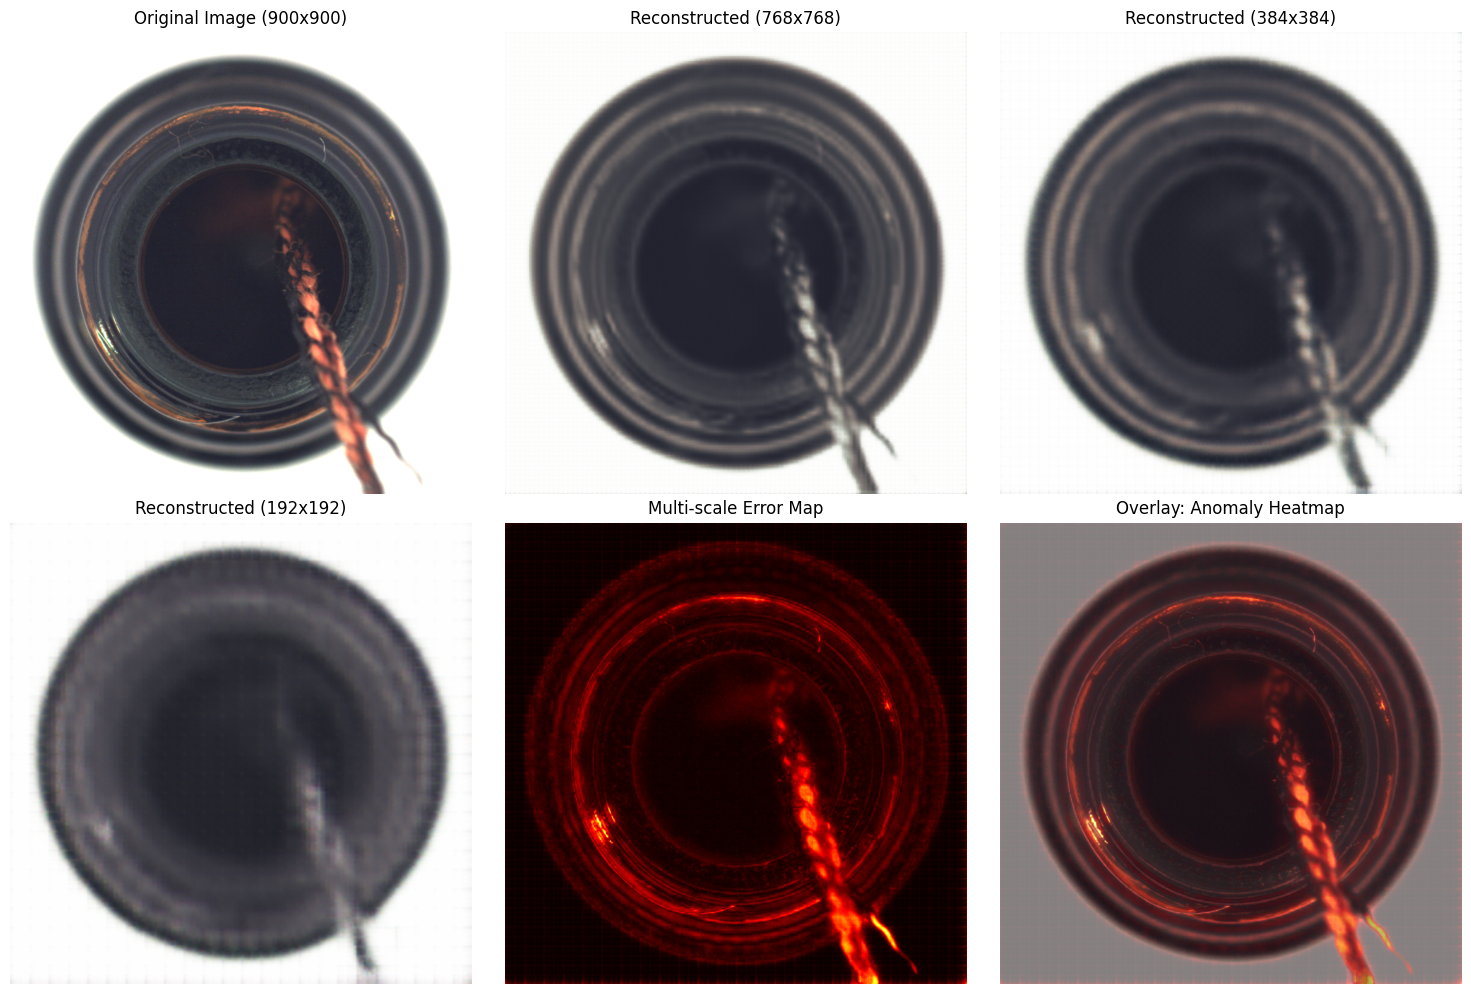

In [7]:
import torch
import torch.nn as nn
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# --- Parameters ---
device = 'cuda' if torch.cuda.is_available() else 'cpu'
scales = [768, 384, 192]
defect_dir = '/content/drive/MyDrive/ML/Datasets/mvtec_ad/contamination'

# --- Load trained models ---
models = []
for s in scales:
    model = SparseAutoencoder().to(device)
    model.load_state_dict(torch.load(f"sparse_autoencoder_{s}.pth", map_location=device))
    model.eval()
    models.append(model)
print("✅ Models loaded successfully")

# --- Pick one defective image to test ---
img_path = os.path.join(defect_dir, os.listdir(defect_dir)[0])
test_img = cv2.imread(img_path)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB) / 255.0

# --- Inference ---
error_maps = []
reconstructed_imgs = []

with torch.no_grad():
    for s, model in zip(scales, models):
        resized = cv2.resize(test_img, (s, s), interpolation=cv2.INTER_AREA)
        inp = torch.tensor(resized).permute(2, 0, 1).unsqueeze(0).float().to(device)
        recon, _ = model(inp)
        recon = recon.squeeze().permute(1, 2, 0).cpu().numpy()

        # Reconstruction error
        diff = np.mean(np.abs(resized - recon), axis=2)
        diff = cv2.resize(diff, (900, 900))
        error_maps.append(diff)
        reconstructed_imgs.append(recon)

# --- Combine error maps ---
final_error = np.mean(np.stack(error_maps), axis=0)
final_error_norm = (final_error - final_error.min()) / (final_error.max() - final_error.min())

# --- Visualize results ---
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.imshow(test_img)
plt.title("Original Image (900x900)")
plt.axis('off')

for i, (s, recon, diff) in enumerate(zip(scales, reconstructed_imgs, error_maps)):
    plt.subplot(2, 3, i+2)
    plt.imshow(cv2.resize(recon, (900, 900)))
    plt.title(f"Reconstructed ({s}x{s})")
    plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(final_error_norm, cmap='hot')
plt.title("Multi-scale Error Map")
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(test_img)
plt.imshow(final_error_norm, cmap='hot', alpha=0.5)
plt.title("Overlay: Anomaly Heatmap")
plt.axis('off')

plt.tight_layout()
plt.show()


✅ Models loaded successfully


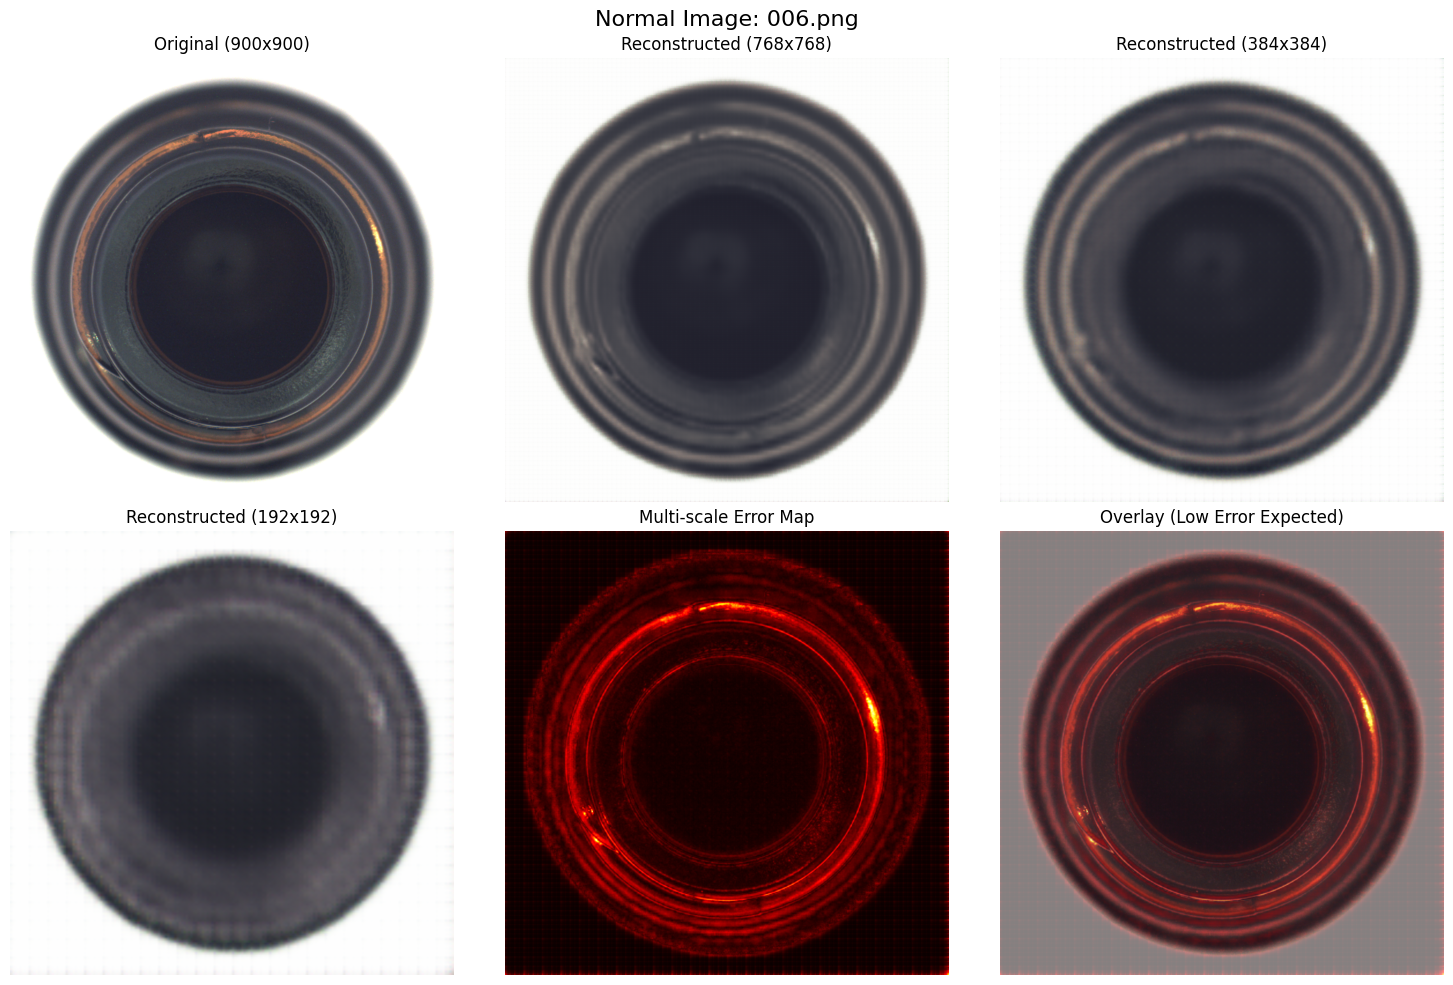

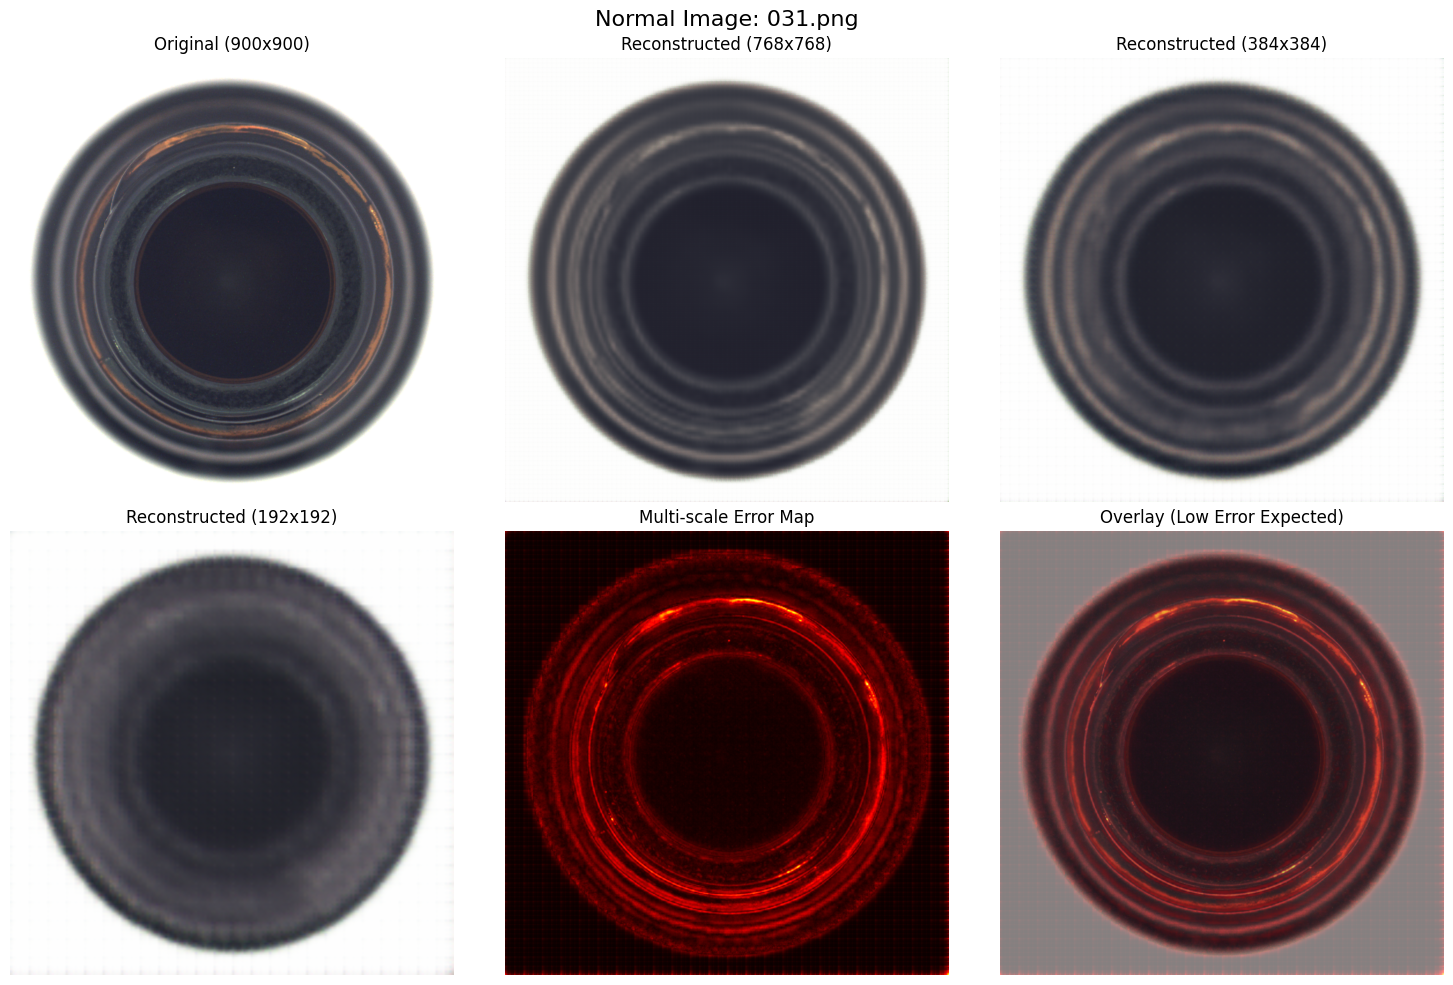

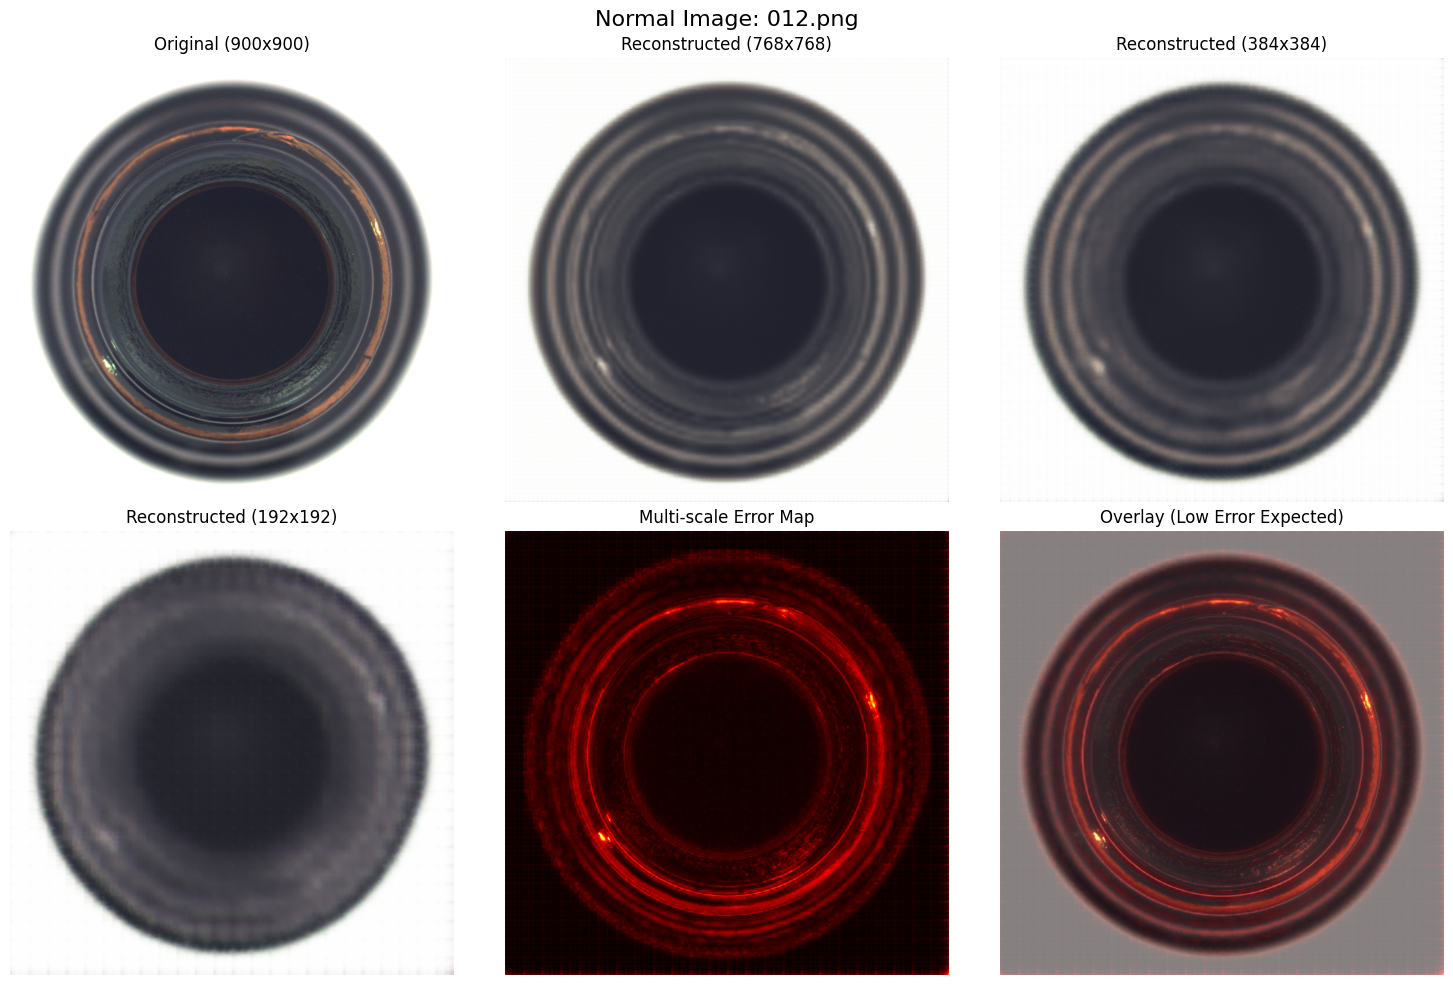

In [8]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# --- Parameters ---
device = 'cuda' if torch.cuda.is_available() else 'cpu'
scales = [768, 384, 192]
normal_dir = '/content/drive/MyDrive/ML/Datasets/mvtec_ad/normal'

# --- Load trained models ---
models = []
for s in scales:
    model = SparseAutoencoder().to(device)
    model.load_state_dict(torch.load(f"sparse_autoencoder_{s}.pth", map_location=device))
    model.eval()
    models.append(model)
print("✅ Models loaded successfully")

# --- Pick one or a few normal images ---
normal_images = [os.path.join(normal_dir, f) for f in os.listdir(normal_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

# --- Loop through some examples ---
for img_path in normal_images[:3]:   # visualize first 3, you can change this
    test_img = cv2.imread(img_path)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB) / 255.0

    error_maps = []
    reconstructed_imgs = []

    with torch.no_grad():
        for s, model in zip(scales, models):
            resized = cv2.resize(test_img, (s, s), interpolation=cv2.INTER_AREA)
            inp = torch.tensor(resized).permute(2, 0, 1).unsqueeze(0).float().to(device)
            recon, _ = model(inp)
            recon = recon.squeeze().permute(1, 2, 0).cpu().numpy()

            # Reconstruction error
            diff = np.mean(np.abs(resized - recon), axis=2)
            diff = cv2.resize(diff, (900, 900))
            error_maps.append(diff)
            reconstructed_imgs.append(recon)

    final_error = np.mean(np.stack(error_maps), axis=0)
    final_error_norm = (final_error - final_error.min()) / (final_error.max() - final_error.min())

    # --- Visualization ---
    plt.figure(figsize=(15, 10))
    plt.suptitle(f"Normal Image: {os.path.basename(img_path)}", fontsize=16)

    plt.subplot(2, 3, 1)
    plt.imshow(test_img)
    plt.title("Original (900x900)")
    plt.axis('off')

    for i, (s, recon) in enumerate(zip(scales, reconstructed_imgs)):
        plt.subplot(2, 3, i+2)
        plt.imshow(cv2.resize(recon, (900, 900)))
        plt.title(f"Reconstructed ({s}x{s})")
        plt.axis('off')

    plt.subplot(2, 3, 5)
    plt.imshow(final_error_norm, cmap='hot')
    plt.title("Multi-scale Error Map")
    plt.axis('off')

    plt.subplot(2, 3, 6)
    plt.imshow(test_img)
    plt.imshow(final_error_norm, cmap='hot', alpha=0.5)
    plt.title("Overlay (Low Error Expected)")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


Found 209 normal images.


Processing normal images: 100%|██████████| 209/209 [00:13<00:00, 16.05it/s]



✅ Threshold for anomaly detection = 0.02244


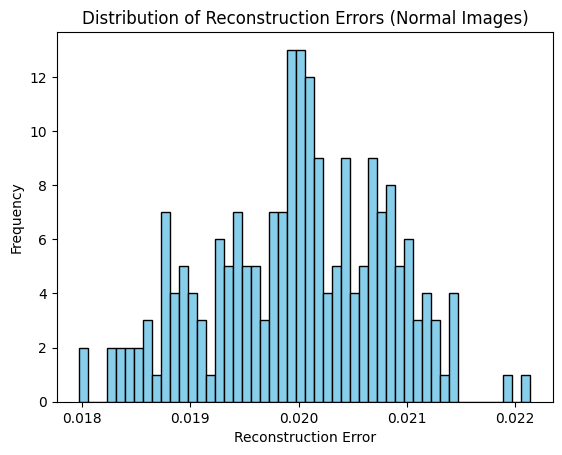

In [10]:
import os, cv2, torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# define device and scales
device = 'cuda' if torch.cuda.is_available() else 'cpu'
scales = [768, 384, 192]

# get all image paths from the normal dataset
normal_training_images = [
    os.path.join(dataset_dir, f)
    for f in os.listdir(normal_dir)
    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
]

print(f"Found {len(normal_training_images)} normal images.")

all_normal_errors = []

for img_path in tqdm(normal_training_images, desc="Processing normal images"):
    test_img = cv2.imread(img_path)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB) / 255.0

    diff_values = []
    with torch.no_grad():
        for s, model in zip(scales, models):  # assumes you already have trained models list
            resized = cv2.resize(test_img, (s, s))
            inp = torch.tensor(resized).permute(2, 0, 1).unsqueeze(0).float().to(device)
            recon, _ = model(inp)
            diff = torch.abs(inp - recon).mean().item()
            diff_values.append(diff)

    all_normal_errors.append(np.mean(diff_values))

# Compute statistical threshold
mean_error = np.mean(all_normal_errors)
std_error = np.std(all_normal_errors)
threshold = mean_error + 3 * std_error  # 3-sigma rule

print(f"\n✅ Threshold for anomaly detection = {threshold:.5f}")

# Optional visualization
plt.hist(all_normal_errors, bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Reconstruction Errors (Normal Images)")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.show()


✅ Models loaded successfully
Using threshold = 0.02244

Testing normal images:
006.png: Normal (Error=0.01996)
031.png: Normal (Error=0.01911)
012.png: Normal (Error=0.02085)
021.png: Normal (Error=0.02115)
003.png: Normal (Error=0.02012)

Testing defective images:
007.png: Defective (Error=0.02383)


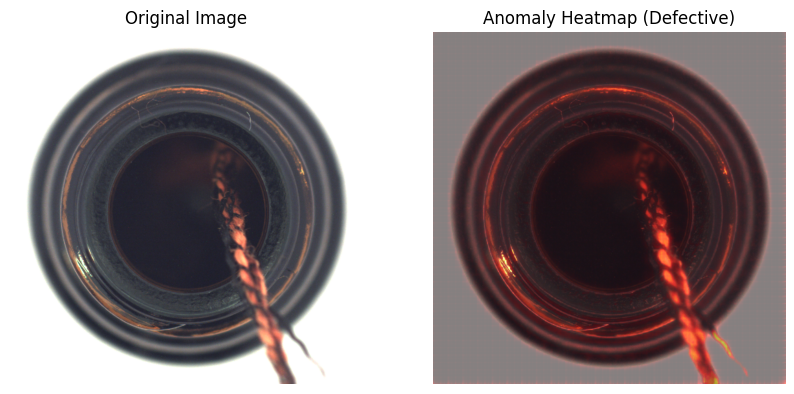

006.png: Defective (Error=0.02959)


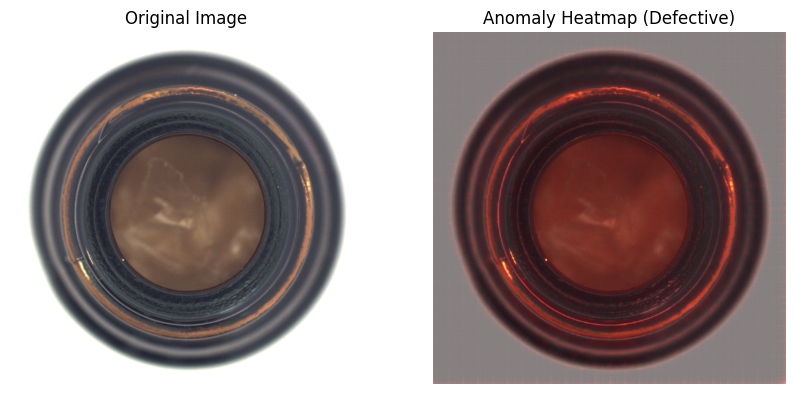

020 (1).png: Defective (Error=0.02546)


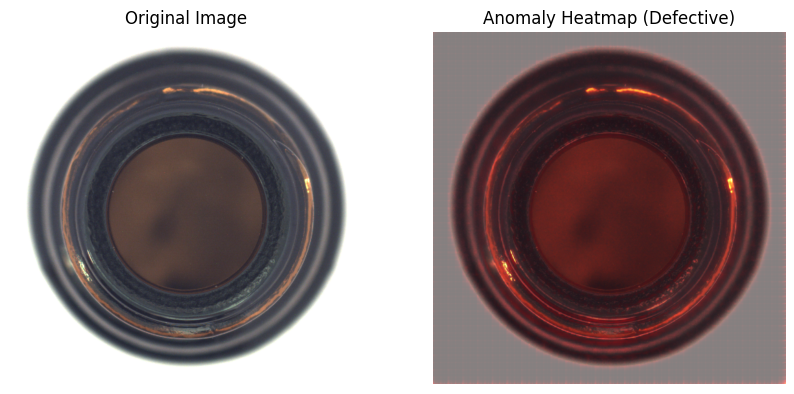

004.png: Normal (Error=0.02033)


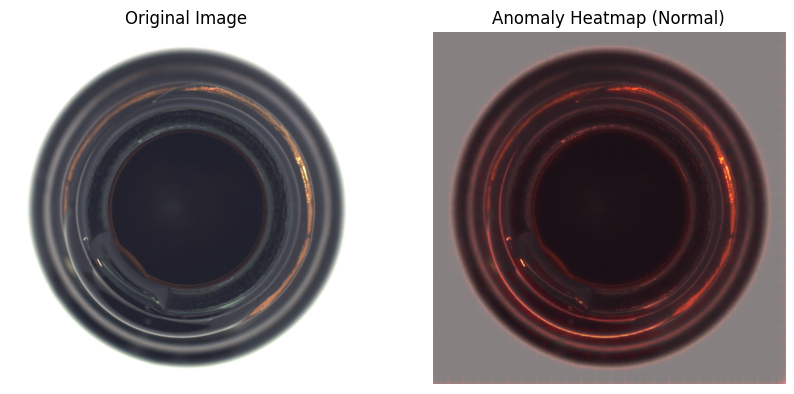

008.png: Normal (Error=0.01788)


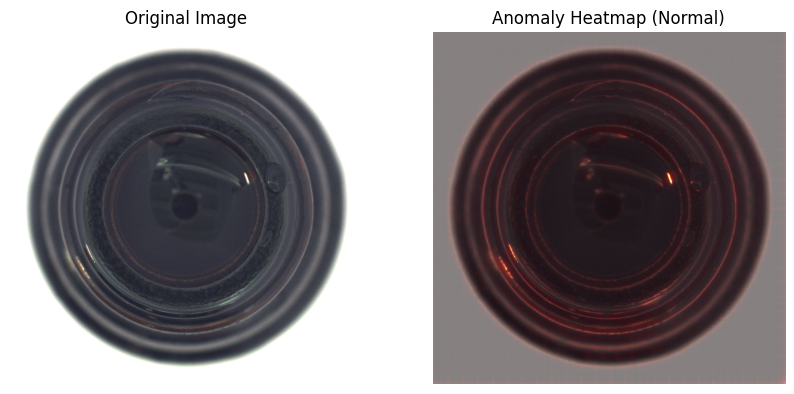

In [11]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

# --- Parameters ---
device = 'cuda' if torch.cuda.is_available() else 'cpu'
scales = [768, 384, 192]

normal_dir = '/content/drive/MyDrive/ML/Datasets/mvtec_ad/normal'
defect_dir = '/content/drive/MyDrive/ML/Datasets/mvtec_ad/contamination'

# --- Load trained models ---
models = []
for s in scales:
    model = SparseAutoencoder().to(device)
    model.load_state_dict(torch.load(f"sparse_autoencoder_{s}.pth", map_location=device))
    model.eval()
    models.append(model)
print("✅ Models loaded successfully")

# --- Threshold (computed previously) ---
# Assume you already have `threshold` from normal images
print(f"Using threshold = {threshold:.5f}")

# --- Function to compute multi-scale reconstruction error ---
def compute_error(img_path, models, scales, device):
    test_img = cv2.imread(img_path)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB) / 255.0
    error_maps = []

    with torch.no_grad():
        for s, model in zip(scales, models):
            resized = cv2.resize(test_img, (s, s))
            inp = torch.tensor(resized).permute(2,0,1).unsqueeze(0).float().to(device)
            recon, _ = model(inp)
            recon = recon.squeeze().permute(1,2,0).cpu().numpy()
            diff = np.mean(np.abs(resized - recon), axis=2)
            diff = cv2.resize(diff, (900, 900))
            error_maps.append(diff)

    final_error = np.mean(np.stack(error_maps))
    return final_error, test_img, np.mean(np.stack(error_maps), axis=0)

# --- Test normal images ---
print("\nTesting normal images:")
normal_images = [os.path.join(normal_dir, f) for f in os.listdir(normal_dir)
                 if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

for img_path in normal_images[:5]:  # test first 5 for demo
    error_value, test_img, error_map = compute_error(img_path, models, scales, device)
    status = "Defective" if error_value > threshold else "Normal"
    print(f"{os.path.basename(img_path)}: {status} (Error={error_value:.5f})")

# --- Test defective images ---
print("\nTesting defective images:")
defect_images = [os.path.join(defect_dir, f) for f in os.listdir(defect_dir)
                 if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

for img_path in defect_images[:5]:  # test first 5 for demo
    error_value, test_img, error_map = compute_error(img_path, models, scales, device)
    status = "Defective" if error_value > threshold else "Normal"
    print(f"{os.path.basename(img_path)}: {status} (Error={error_value:.5f})")

    # Optional visualization
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(test_img)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(test_img)
    plt.imshow(error_map, cmap='hot', alpha=0.5)
    plt.title(f"Anomaly Heatmap ({status})")
    plt.axis('off')
    plt.show()
